## Error Analysis 

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")
# if is_private():
import gc
import cv2
import copy
import time
import random
from scipy.stats import rankdata

# For data manipulation
# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel,AutoConfig
from nltk.corpus import stopwords
# Utils
import pickle

In [2]:
TRAIN_DATA_PATH = "/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-comment-classification-challenge/train.csv"
VALID_DATA_PATH = "/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-severity-rating/validation_data.csv"
# TEST_DATA_PATH = "/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-severity-rating/comments_to_score.csv"

In [3]:
valid=pd.read_csv(VALID_DATA_PATH)

In [4]:
valid

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


Using the same tokenizer and similar architecture to that used in modelling to use the saved model to run on validation data which contains less_toxic and more_toxic columns , which are to be considered as 0 and 1 as their respective scores.

In [7]:

df_train2 = pd.read_csv(TRAIN_DATA_PATH)
df_valid2 = pd.read_csv(VALID_DATA_PATH)
# df_test2 = pd.read_csv(TEST_DATA_PATH)
cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_mtpl:
    df_train2[category] = df_train2[category] * cat_mtpl[category]

df_train2['score'] = df_train2.loc[:, 'toxic':'identity_hate'].mean(axis=1)

df_train2['y'] = df_train2['score']

min_len = (df_train2['y'] > 0).sum()  # len of toxic comments
df_y0_undersample = df_train2[df_train2['y'] == 0].sample(n=min_len, random_state=41)  # take non toxic comments
df_train_new = pd.concat([df_train2[df_train2['y'] > 0], df_y0_undersample])  # make new df
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None)

raw_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
raw_tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
from datasets import Dataset

dataset = Dataset.from_pandas(df_train_new[['comment_text']])

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["comment_text"]

raw_tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

def dummy_fun(doc):
    return doc

labels = df_train_new['y']
comments = df_train_new['comment_text']
tokenized_comments = tokenizer(comments.to_list())['input_ids']



comments_tr = vectorizer.fit_transform(tokenized_comments)

regressor = pickle.load(open("/Users/rupesh/Downloads/Toxicity /finalized_model.sav", 'rb'))

regressor.fit(comments_tr, labels)


less_toxic_comments = df_valid2['less_toxic']
more_toxic_comments = df_valid2['more_toxic']

less_toxic_comments = tokenizer(less_toxic_comments.to_list())['input_ids']
more_toxic_comments = tokenizer(more_toxic_comments.to_list())['input_ids']

less_toxic = vectorizer.transform(less_toxic_comments)
more_toxic = vectorizer.transform(more_toxic_comments)

# make predictions
y_pred_less = regressor.predict(less_toxic)
y_pred_more = regressor.predict(more_toxic)


In [8]:
er_less=df_valid2['less_toxic'].tolist()

In [9]:
er_less_df = pd.DataFrame({'Less_toxic':df_valid2['less_toxic'].tolist(), 'pred_score':y_pred_less})

In [21]:
er_less_df=er_less_df.sort_values('pred_score', ascending=False)
er_less_df

,Less_toxic,pred_score
4865,Hey Man\nYou are a retarded Mexican cocksuckin...,0.708232
4866,Hey Man\nYou are a retarded Mexican cocksuckin...,0.708232
8100,AND YOUR A FUCKING GAY BITCH,0.645232
19144,AND YOUR A FUCKING GAY BITCH,0.645232
8099,AND YOUR A FUCKING GAY BITCH,0.645232
...,...,...
25975,Hi DeltaQuad. In my opinion user Nmate does no...,-0.069424
25976,Hi DeltaQuad. In my opinion user Nmate does no...,-0.069424
6388,"has been determined, using CheckUser, to be a...",-0.072551
6389,"has been determined, using CheckUser, to be a...",-0.072551


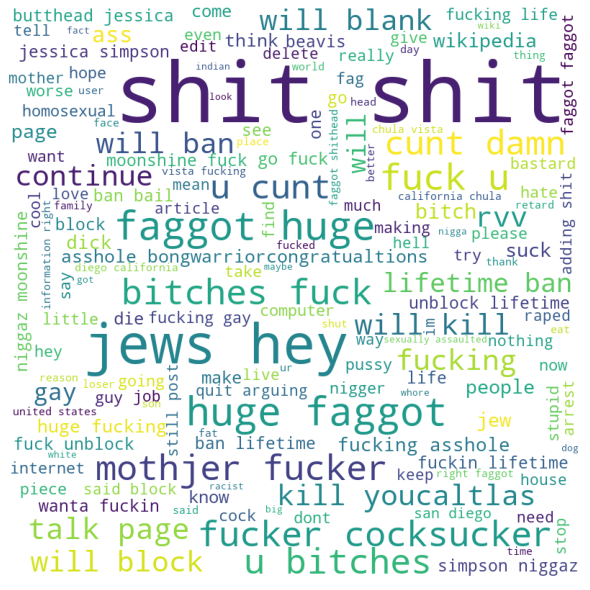

In [11]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads 'Youtube04-Eminem.csv' file
df =er_less_df.iloc[:1000]['Less_toxic']

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


As we see in the less toxic comments (0) there are some comments which can actually be considered to be more toxic comments while considering the comments but are placed in less toxic comments. 
Also the model is also recognising the mispelled words also.

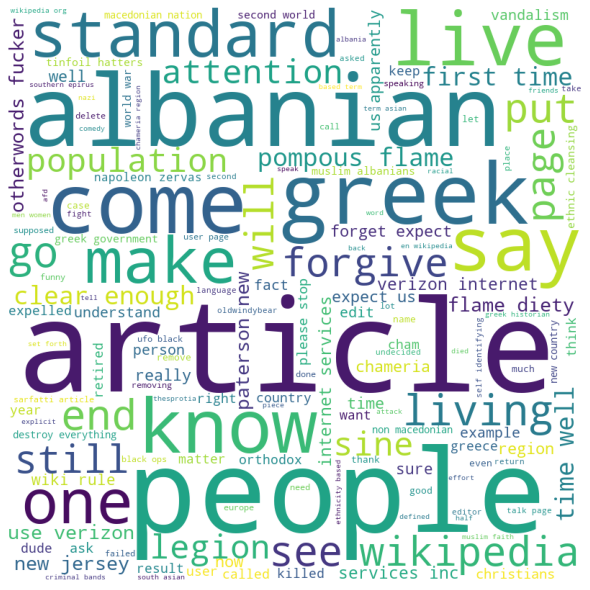

In [20]:
df =er_less_df.iloc[14954:15154]['Less_toxic']

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()



The average scored comments are actualy aligned with less toxic comments score 

In [12]:
er_more_df = pd.DataFrame({'More_toxic':df_valid2['less_toxic'].tolist(), 'pred_score':y_pred_more})

In [13]:
er_more_df=er_more_df.sort_values('pred_score')

In [22]:
er_more_df

,More_toxic,pred_score
22113,WARNING ABOUT RODHULLANDEMU\n\nWarning! This u...,-0.067962
290,"""\n\nwikipedia entry on ten-string guitar can ...",-0.065150
291,"""\n\nwikipedia entry on ten-string guitar can ...",-0.065150
14515,"""\n\n""""- ==Message for Other Editors== \n- ...",-0.061170
14516,"""\n\n""""- ==Message for Other Editors== \n- ...",-0.061170
...,...,...
28282,fuck malaysians\nMalaysians are a fucked race ...,0.804435
28283,fuck malaysians\nMalaysians are a fucked race ...,0.804435
11494,"""\n Oh, oh wait, even better yet: Touting your...",0.865169
11493,"""\n Oh, oh wait, even better yet: Touting your...",0.865169


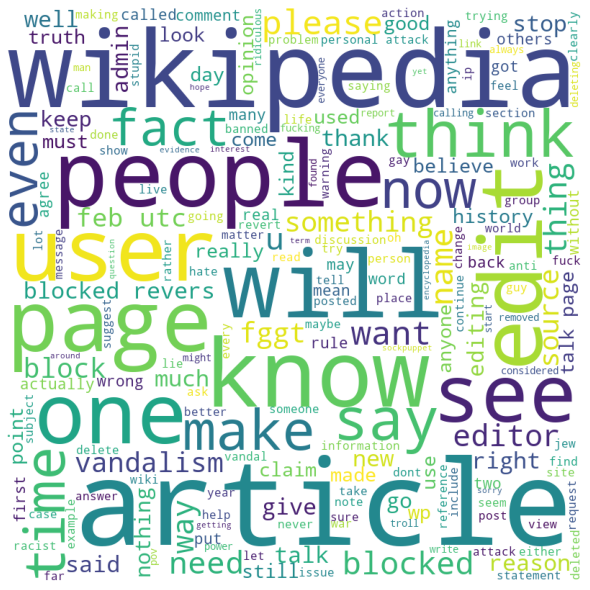

In [14]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads 'Youtube04-Eminem.csv' file
df =er_more_df.iloc[:1000]['More_toxic']

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()



Here the words shown in the more toxic comments (1) which are scored with lower values , which is aligned with the words which are represented above , except for very few outliers the model is performing in alignment with our goals .

## Conclusions :

With the help of word clouds we see that the main model is perfoming well and scoring the comments accordingly.

In [ ]:

df_train2 = pd.read_csv(TRAIN_DATA_PATH)
df_valid2 = pd.read_csv(VALID_DATA_PATH)
# df_test2 = pd.read_csv(TEST_DATA_PATH)
cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_mtpl:
    df_train2[category] = df_train2[category] * cat_mtpl[category]

df_train2['score'] = df_train2.loc[:, 'toxic':'identity_hate'].mean(axis=1)

df_train2['y'] = df_train2['score']

min_len = (df_train2['y'] > 0).sum()  # len of toxic comments
df_y0_undersample = df_train2[df_train2['y'] == 0].sample(n=min_len, random_state=41)  # take non toxic comments
df_train_new = pd.concat([df_train2[df_train2['y'] > 0], df_y0_undersample])  # make new df
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None)

raw_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
raw_tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
from datasets import Dataset

dataset = Dataset.from_pandas(df_train_new[['comment_text']])

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["comment_text"]

raw_tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

def dummy_fun(doc):
    return doc

labels = df_train_new['y']
comments = df_train_new['comment_text']
tokenized_comments = tokenizer(comments.to_list())['input_ids']



comments_tr = vectorizer.fit_transform(tokenized_comments)

# Importing the already trained model 
regressor = pickle.load(open("/Users/rupesh/Downloads/Toxicity /finalized_model.sav", 'rb'))

regressor.fit(comments_tr, labels)

less_toxic_comments = df_valid2['less_toxic']
more_toxic_comments = df_valid2['more_toxic']

less_toxic_comments = tokenizer(less_toxic_comments.to_list())['input_ids']
more_toxic_comments = tokenizer(more_toxic_comments.to_list())['input_ids']

less_toxic = vectorizer.transform(less_toxic_comments)
more_toxic = vectorizer.transform(more_toxic_comments)

# make predictions
y_pred_less = regressor.predict(less_toxic)
y_pred_more = regressor.predict(more_toxic)


